In [14]:
%%bash
# remove everything except this notebook
shopt -s extglob
rm -rf !("notebook.ipynb") 
# to test any error in the terminal, use:
# ipython3 -c "%run notebook.ipynb"

In [15]:
import sys, os; sys.path.append(os.path.realpath(os.path.join(os.getcwd(), "../")))
from tools import *
# while updating modules
# import importlib; importlib.reload(directory_scraping)

# create empty directories
dirs_dict = {'raw_ligands':'./raw_ligands/', 'prepared_ligands':'./prepared_ligands/'}
directory_scraping.prepare_directory_from_dict(dirs_dict)

check the protonation state of the molecules before docking
> In chemistry, protonation (or hydronation) is the adding of a proton (or hydron, or hydrogen cation), (H+) to an atom, molecule, or ion, forming a conjugate acid. (The complementary process, when a proton is removed from a Brønsted–Lowry acid, is deprotonation.)

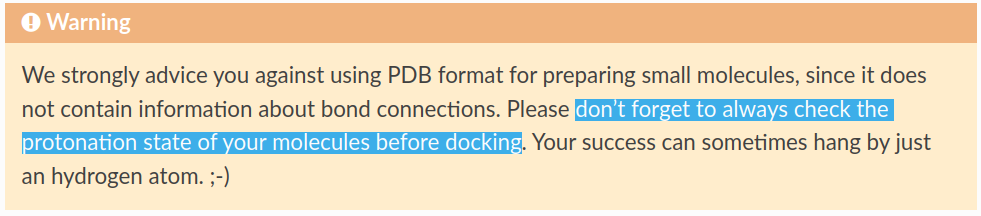

# using python-meeko iterating over lines in txt file (each line represent a molecule in SMILES format)

In [16]:
# the example molecules where obtained from Wikipedia
# https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system#Examples

# refs:
# https://www.blopig.com/blog/2022/08/meeko-docking-straight-from-smiles-string/

In [17]:
%%file {dirs_dict['raw_ligands']}list_ligands.txt
N#N
CN=C=O
O=Cc1ccc(O)c(OC)c1
COc1cc(C=O)ccc1O
CC(=O)NCCC1=CNc2c1cc(OC)cc2
CC(=O)NCCc1c[nH]c2ccc(OC)cc12
CCc(c1)ccc2[n+]1ccc3c2[nH]c4c3cccc4
CCc1c[n+]2ccc3c4ccccc4[nH]c3c2cc1
CN1CCC[C@H]1c2cccnc2
CCC[C@@H](O)CC\C=C\C=C\C#CC#C\C=C\CO
CCC[C@@H](O)CC/C=C/C=C/C#CC#C/C=C/CO
CC1=C(C(=O)C[C@@H]1OC(=O)[C@@H]2[C@H](C2(C)C)/C=C(\C)/C(=O)OC)C/C=C\C=C
O1C=C[C@H]([C@H]1O2)c3c2cc(OC)c4c3OC(=O)C5=C4CCC(=O)5
OC[C@@H](O1)[C@@H](O)[C@H](O)[C@@H](O)[C@H](O)1
OC[C@@H](O1)[C@@H](O)[C@H](O)[C@@H]2[C@@H]1c3c(O)c(OC)c(O)cc3C(=O)O2
CC(=O)OCCC(/C)=C\C[C@H](C(C)=C)CCC=C
CC[C@H](O1)CC[C@@]12CCCO2
CC(C)[C@@]12C[C@@H]1[C@@H](C)C(=O)C2
OCCc1c(C)[n+](cs1)Cc2cnc(C)nc2N

Writing ./raw_ligands/list_ligands.txt


In [59]:
# DELETE
importlib.reload(ligand_preparation)

# ---------------

import rdkit
import meeko

import pandas as pd
from tqdm import tqdm


# create dataframe to register the optimal box size for each ligand
ligands_opt_box_size = pd.DataFrame(columns=['ligand_name', 'optimal_box_size', 'euclid_dist_origin', 'ligand_center'])

with open(dirs_dict['raw_ligands']+'list_ligands.txt') as f:
    ligand_smis = f.readlines()

# clear output directory
directory_scraping.mkdir_or_clear(dirs_dict['prepared_ligands'])
    
for idx, ligand_smi in enumerate(tqdm(ligand_smis), start=1):
    ligand_name = 'ligand_' + f'{idx:03}'
    ligand_smi = ligand_smi.strip()
    # print(ligand_name, ligand_smi)
    # load our ligand from SMILES into RDKit
    lig = rdkit.Chem.MolFromSmiles(ligand_smi)
    # add hydrogens (without regard to pH) 
    protonated_lig = rdkit.Chem.AddHs(lig)
    # generate 3D coordinates for the ligand
    rdkit.Chem.AllChem.EmbedMolecule(protonated_lig)
    # convert to a PDBQT string using the MoleculePreparation class from Meeko.
    meeko_prep = meeko.MoleculePreparation()
    meeko_prep.prepare(protonated_lig)
    lig_pdbqt = meeko_prep.write_pdbqt_string()
    # At this point, pdbqt_string can be written to a file for docking with AutoDock-GPU or Vina, or passed directly to Vina within Python using set_ligand_from_string(pdbqt_string)
    out_file_path = dirs_dict['prepared_ligands'] + ligand_name + '.pdbqt'
    with open(out_file_path, "w") as text_file:
        text_file.write(lig_pdbqt)
    # compute optimal box size using https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4468813/
    optimal_box_size = ligand_preparation.get_optimal_box_size_for_ligand(out_file_path)
    # compute ligand center to make sure it is close to the origin
    ligand_center, euclid_dist_origin = ligand_preparation.get_ligand_center(meeko_prep)
    # update dataframe
    ligands_opt_box_size = ligands_opt_box_size.append({'ligand_name':ligand_name, 'optimal_box_size':optimal_box_size, 'ligand_center':ligand_center, 'euclid_dist_origin':euclid_dist_origin}, ignore_index=True)
        
# save dataframe to csv file
ligands_opt_box_size.to_csv(dirs_dict['prepared_ligands']+'ligands_opt_box_size.csv', sep='\t')
# print dataframe
ligands_opt_box_size

100%|██████████| 19/19 [00:01<00:00, 14.61it/s]


,ligand_name,optimal_box_size,euclid_dist_origin,ligand_center
0,ligand_001,2.426,0.000000,"[0.00, 0.00, 0.00]"
1,ligand_002,5.854,0.917121,"[0.91, -0.10, 0.05]"
2,ligand_003,10.129,0.492284,"[-0.24, 0.42, -0.09]"
3,ligand_004,10.066,0.469516,"[-0.14, 0.39, 0.23]"
4,ligand_005,13.210,0.451361,"[0.07, -0.44, 0.07]"
5,ligand_006,14.723,0.451394,"[0.12, -0.00, -0.44]"
6,ligand_007,14.683,0.589263,"[-0.58, -0.07, -0.04]"
7,ligand_008,14.696,0.592188,"[-0.58, -0.00, 0.13]"
8,ligand_009,10.382,0.487151,"[0.44, 0.06, 0.19]"
9,ligand_010,25.808,1.252937,"[1.25, 0.02, 0.10]"


# using python-meeko iterating over files in directory

In [ ]:
# put some raw ligand files into the "raw_ligands" directory
# -P prefix --directory-prefix=prefix Set directory prefix to prefix.
!rm raw_ligands/*
!wget -P raw_ligands/ https://raw.githubusercontent.com/ccsb-scripps/AutoDock-Vina/develop/example/basic_docking/data/1iep_ligand.sdf
!wget -O raw_ligands/1iep_ligand_G_STI.sdf "https://models.rcsb.org/v1/1iep/ligand?auth_seq_id=201&label_asym_id=G&encoding=sdf&filename=1iep_G_STI.sdf"
!ls raw_ligands/

In [11]:
from meeko import MoleculePreparation
import os, sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), "../")))
from tools import *

dir_raw_ligands = 'raw_ligands/'
dir_prepared_ligands = 'prepared_ligands/'
directory_scraping.mkdir_or_clear(dir_prepared_ligands)

In [30]:
# get all ligands in directory
ligand_paths, ligand_names = directory_scraping.list_files_in_dir(directory=dir_raw_ligands, search_pattern='*')

# iterate over ligands and prepare pdbqt files
for i,ligand_path in enumerate(ligand_paths):
    print("\n", "-"*50, "\n\n", ligand_path, "\n")
    ligand_name = ligand_names[i]
    mol = ligand_preparation.prepare_mols_from_sdf(ligand_path)[0]
    # prepare meeko object
    mkprep = MoleculePreparation()
    mkprep.prepare(mol)
    # preparator.show_setup()
    ligand_preparation.print_ligand_center(mkprep)
    # At this point, pdbqt_string can be written to a file for docking with AutoDock-GPU or Vina, or passed directly to Vina within Python using set_ligand_from_string(pdbqt_string)
    with open(dir_prepared_ligands + ligand_name + ".pdbqt", "w") as text_file:
        text_file.write(mkprep.write_pdbqt_string())


 -------------------------------------------------- 

 raw_ligands/1iep_ligand.sdf 

ligand center:    0.996   -0.061   -0.026

 -------------------------------------------------- 

 raw_ligands/1iep_ligand_G_STI.sdf 

ligand center:    1.069   -0.026   -0.113


# draw ligands before and after preparation (highlight differences).

In [57]:
import py3Dmol
from rdkit import Chem
# from rdkit.Chem import AllChem, Draw

for i,ligand_path in enumerate(ligand_paths):
    print("\n", "-"*50, "\n\n", ligand_path, "\n")
    ligand_name = ligand_names[i]
    mol_raw = Chem.SDMolSupplier(ligand_path)[0]
    mol_prep = ligand_preparation.prepare_mols_from_sdf(ligand_path)[0]

    view = py3Dmol.view()
    view.removeAllModels()
    view.setViewStyle({'style':'outline','color':'black','width':0.1})
    
    view.addModel(Chem.MolToMolBlock(mol_raw,False),'mol')
    x = view.getModel()
    x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})
    
    view.zoomTo()
    view.show()
    
    # --------------
    
    view = py3Dmol.view()
    view.removeAllModels()
    view.setViewStyle({'style':'outline','color':'black','width':0.1})
    
    view.addModel(Chem.MolToMolBlock(mol_prep,False),'mol')
    x = view.getModel()
    x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})
    
    view.zoomTo()
    view.show()
    
# results=Chem.SDMolSupplier('1AZ8_lig_vina_out.sdf')
# p=Chem.MolToMolBlock(results[0],False)
# view.addModel(p,'mol')
# view.zoomTo()
# view.show()


 -------------------------------------------------- 

 raw_ligands/1iep_ligand.sdf 



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol


 -------------------------------------------------- 

 raw_ligands/1iep_ligand_G_STI.sdf 



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol


 -------------------------------------------------- 

 raw_ligands/1iep_ligand.sdf 



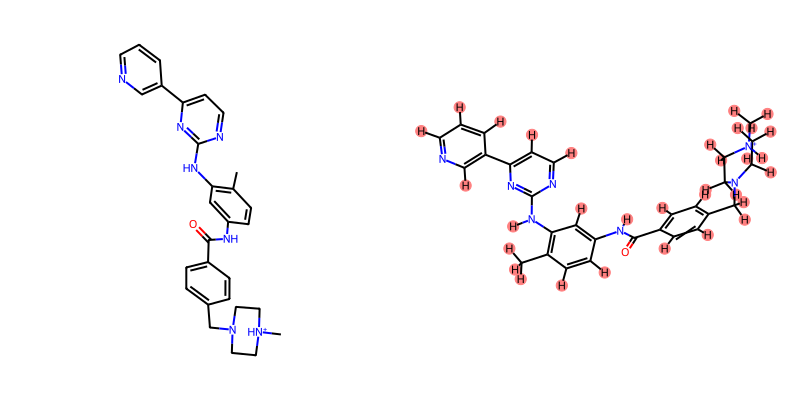


 -------------------------------------------------- 

 raw_ligands/1iep_ligand_G_STI.sdf 



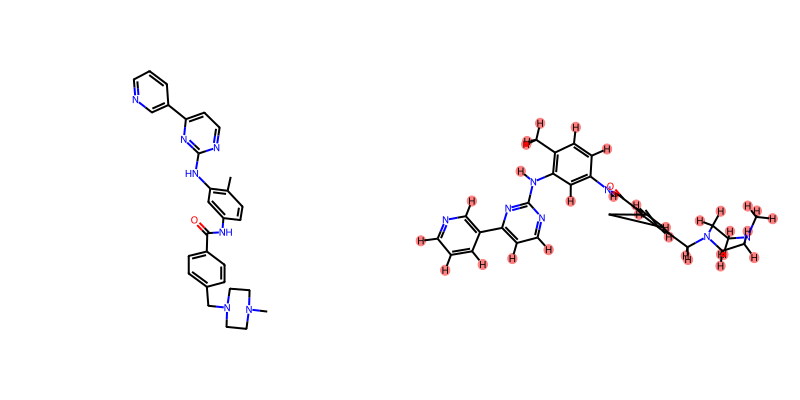

In [52]:
from rdkit import Chem
from rdkit.Chem import Draw

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem import rdFMCS
rdDepictor.SetPreferCoordGen(True)
# IPythonConsole.drawOptions.minFontSize=10

def view_difference(mol1, mol2):
    mcs = rdFMCS.FindMCS([mol1,mol2])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = mol1.GetSubstructMatch(mcs_mol)
    target_atm1 = []
    for atom in mol1.GetAtoms():
        if atom.GetIdx() not in match1:
            target_atm1.append(atom.GetIdx())
    match2 = mol2.GetSubstructMatch(mcs_mol)
    target_atm2 = []
    for atom in mol2.GetAtoms():
        if atom.GetIdx() not in match2:
            target_atm2.append(atom.GetIdx())
    return Draw.MolsToGridImage([mol1, mol2],highlightAtomLists=[target_atm1, target_atm2], molsPerRow=2,subImgSize=(400,400))

for i,ligand_path in enumerate(ligand_paths):
    print("\n", "-"*50, "\n\n", ligand_path, "\n")
    ligand_name = ligand_names[i]
    mol_raw = Chem.SDMolSupplier(ligand_path)[0]
    mol_prep = ligand_preparation.prepare_mols_from_sdf(ligand_path)[0]
    # display(mol_raw, mol_prep)
    # display(Draw.MolsToGridImage([mol_raw, mol_prep]))
    display(view_difference(mol_raw, mol_prep))

# using bash and two conda environments

In [31]:
%%file check_ligand_protonation.py
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Check the protonation state of the molecules before docking.
In chemistry, protonation (or hydronation) is the adding of a proton (or hydron, or hydrogen cation), (H+) to an atom, molecule, or ion, forming a conjugate acid. (The complementary process, when a proton is removed from a Brønsted–Lowry acid, is deprotonation.)
Usage:
    bash check_ligand_protonation.sh <input file> <output file>
Example:
    bash check_ligand_protonation.sh 1iep_ligand_G_STI.sdf ligand_step01_protonated.sdf
"""

import os
import sys


__author__ = "Carlos Garcia-Hernandez"
__email__ = "carlos.garcia2@bsc.es"

USAGE = __doc__.format(__author__, __email__)

def check_input(args):
    """Validates user input/options.
    """
    if not os.path.isfile(args):
            emsg = 'ERROR!! File not found or not readable: \'{}\'\n'
            sys.stderr.write(emsg.format(args[0]))
            sys.stderr.write(__doc__)
            sys.exit(1)
    return args

def run(infile, outfile):
    """
    Check the protonation state of the molecules before docking.
    Parameters
    ----------
    fhandle : an iterable giving the PDB file line-by-line
    outname : str
        The base name of the output files. If None is given, tries to
        extract a name from the `.name` attribute of `fhandler`. If
        `fhandler` has no attribute name, assigns `splitchains`.
    """
    from openbabel import openbabel as ob
    from meeko import obutils

    mol = obutils.load_molecule_from_file(infile, molecule_format='SDF')

    mol.AddHydrogens()
    charge_model = ob.OBChargeModel.FindType("Gasteiger")
    charge_model.ComputeCharges(mol)

    obutils.writeMolecule(mol, fname=outfile)


def main():
    # Check Input
    args = sys.argv[1:]
    infile = check_input(args[0])
    outfile = args[1]

    # Do the job
    run(infile, outfile)

    # last line of the script
    # We can close it even if it is sys.stdin
    # infile.close()
    # outfile.close()
    sys.exit(0)


if __name__ == '__main__':
    main()

# --------------------------------------------------------------------------
# references:
# add hydrogens to molecules using openbabel
# from: https://github.com/DrrDom/rdkit-scripts/blob/master/vina_dock.py
#       https://github.com/forlilab/Meeko/blob/09610111d43fef2b11636ddd110d1423205a3d47/meeko/utils/obutils.py


Overwriting check_ligand_protonation.py


In [9]:
%%file check_ligand_protonation.sh
#!/bin/bash

source /opt/conda/etc/profile.d/conda.sh
conda activate env_meeko
# mk_prepare_ligand.py $@
python check_ligand_protonation.py $@

Overwriting check_ligand_protonation.sh


In [10]:
!chmod 777 check_ligand_protonation.sh
!ls -l

total 112
-rw-r--r-- 1 jovyan users  2896 Apr 13 12:06 check_ligand_protonation.py
-rwxrwxrwx 1 jovyan users   143 Apr 13 12:06 check_ligand_protonation.sh
-rw-r--r-- 1 jovyan users 95305 Apr 13 12:05 notebook.ipynb
drwxr-xr-x 2 jovyan users  4096 Apr 12 17:12 prepared_ligands
drwxr-xr-x 2 jovyan users  4096 Apr 12 17:30 raw_ligands


In [26]:
# list files in directory
import glob, os
ligand_filepaths = sorted(glob.glob('raw_ligands/*'))
ligand_filenames = list(map(lambda x: os.path.splitext(os.path.basename(x))[0], ligand_filepaths))
ligand_filepaths

['raw_ligands/1iep_ligand.sdf', 'raw_ligands/1iep_ligand_G_STI.sdf']

In [54]:
!rm prepared_ligands/*
for i,ligand_filepath in enumerate(ligand_filepaths):
    print("\n", "-"*50, "\n\n", ligand_filepath, "\n")
    ligand_filename = ligand_filenames[i]; #print(ligand_filename)
    # -------------------------------------------------------------------------------
    # step01: check the protonation state of the molecules before docking
    step01_out = "prepared_ligands/" + ligand_filename +"_step01.sdf"
    !./check_ligand_protonation.sh {ligand_filepath} {step01_out}
    # -------------------------------------------------------------------------------
    # step02: change the format of the molecule to PDBQT
    step02_out = "prepared_ligands/" + ligand_filename + "_step02.pdbqt"
    !prepare_ligand -i {step01_out} -o {step02_out}
    # -------------------------------------------------------------------------------
    !mv {step02_out} "prepared_ligands/"{ligand_filename}".pdbqt"
    !rm prepared_ligands/*_step*
    # -------------------------------------------------------------------------------


 -------------------------------------------------- 

 raw_ligands/1iep_ligand.sdf 


 -------------------------------------------------- 

 raw_ligands/1iep_ligand_G_STI.sdf 



In [55]:
!ls prepared_ligands -l

total 8
-rw-r--r-- 1 jovyan users 3781 Apr 13 12:38 1iep_ligand_G_STI.pdbqt
-rw-r--r-- 1 jovyan users 3871 Apr 13 12:38 1iep_ligand.pdbqt


# try to predict the size of the grid box for a given ligand

refs: 
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4468813/
- https://github.com/michal-brylinski/eboxsize/blob/master/eBoxSize-1.1.pl
- https://www.researchgate.net/publication/277899813_Calculating_an_optimal_box_size_for_ligand_docking_and_virtual_screening_against_experimental_and_predicted_binding_pockets
- https://www.researchgate.net/post/How-can-I-properly-stablish-the-size-of-the-grid-for-a-docking-in-AutoDock-Vina


In [4]:
# !wget https://github.com/michal-brylinski/eboxsize/blob/master/eBoxSize-1.1.pl
!git clone https://github.com/michal-brylinski/eboxsize.git

Cloning into 'eboxsize'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6
Receiving objects: 100% (6/6), done.


In [9]:
# get all ligands in directory
ligand_paths, ligand_names = directory_scraping.list_files_in_dir(directory=dir_pre, search_pattern='*')

# create table with all recommended sizes
# 


boxsize = !perl eboxsize/eBoxSize-1.1.pl prepared_ligands/1iep_ligand.pdbqt
boxsize = float(boxsize[0])
boxsize

27.588